## Inference test on test data set: BERT

References:  

Mehdi Mashayekhi:  
https://github.com/mehdimashayekhi  
Transfer-Learning-in-Natural-Language-Processing  
  
https://www.kaggle.com/code/akshat0007/bert-for-sequence-classification  
  
https://mccormickml.com/2019/07/22/BERT-fine-tuning/  

In [127]:
!nvidia-smi

Thu Dec 26 19:36:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |
| N/A   33C    P0             25W /   70W |    7631MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler,SequentialSampler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import BertModel, AutoConfig
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import nltk
import re
import time
import datetime
import random
import matplotlib.pyplot as plt
%matplotlib inline

2024-12-27 22:36:52.275727: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/soonglee/anaconda3/envs/bert/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [129]:
if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Data preprocessing

In [130]:
df = pd.read_csv('data/train.csv')

In [131]:
df.shape

(7613, 5)

In [132]:
df.sample(5)

,id,keyword,location,text,target
3897,5541,flattened,"Northampton, MA",@JimMozel puck=flattened ball lol,0
872,1263,blood,NaN,Man . somebody gotta stop Sbee dude too fuckin...,0
2122,3049,death,?s????ss? a?????,Ari's hints and snippets will be the death of me.,0
6334,9055,structural%20failure,NaN,@SirTitan45 Mega mood swing on a 24 hr schedu...,0
4423,6294,hostage,NaN,I always tell my mom to bring me food or I wil...,0


In [133]:
def pos_oversampling(df):
    add_pos = 4342 - 3271
    pos_df = df[df["target"] == 1]
    neg_df = df[df["target"] == 0]
    pos_df.reset_index(inplace=True)
    pos_add_indices = np.random.choice(pos_df.index, add_pos, replace=False)
    pos_add_df = pos_df.iloc[pos_add_indices]
    pos_oversampled = pd.concat([pos_df, pos_add_df], ignore_index=True)
    balanced_df = pd.concat([neg_df, pos_oversampled], ignore_index=True)
    return balanced_df

In [134]:
# Due to the imbalance of the dataset, oversample the positive tweets
balanced_df = pos_oversampling(df)

In [135]:
# replace empty cells with a strin "NA"
balanced_df.fillna('NA', inplace=True)

/tmp/ipykernel_1931/1728943000.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  balanced_df.fillna('NA', inplace=True)


In [136]:
# Concatenate keyword, location, and text and name the new column as tweet.
balanced_df['tweet'] = balanced_df['keyword'] + ' ' + balanced_df['location'] + ' ' + balanced_df['text']

### Create sentence and label lists

To use BERT, We need to add special tokens at the beginning and end of each sentence for BERT to work properly

In [137]:
sentences = balanced_df.text.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = balanced_df.target.values

## Inputs

Next, import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.

In [138]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenize the first sentence:
['[CLS]', 'what', "'", 's', 'up', 'man', '?', '[SEP]']


In [139]:
# Set the maximum sequence length. The longest sequence in our training set is 28.
MAX_LEN = 28

In [140]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [141]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Create the attention masks 

In [142]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

Use train_test_split to split our data into train and validation sets for training

In [143]:
tr_inputs, test_inputs, tr_labels, test_labels = train_test_split(input_ids, labels, test_size=0.20, random_state=38)
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(tr_inputs, tr_labels, test_size=0.25, random_state=28)
tr_masks, test_masks, _, _ = train_test_split(attention_masks, input_ids, test_size=0.20, random_state=38)
train_masks, validation_masks, _, _ = train_test_split(tr_masks, tr_inputs, test_size=0.25, random_state=28)

In [144]:
# Convert all of our data into torch tensors, the required type for our pytorch model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

Select a batch size for training. 

For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32. Create an iterator of our data with torch DataLoader. 

In [145]:
batch_size = 16

# Training
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Validation
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


### Model set up

In [146]:
## Hyper-parameters

epochs = 4
lr = 2e-5
eps = 1e-8
num_labels = 2
random_seed = 38

#### Hyperparameter change in BERT pre-trained model

In [147]:
configuration = AutoConfig.from_pretrained('bert-base-uncased')

In [148]:
configuration.hidden_dropout_prob = 0.1
configuration.attention_probs_dropout_prob = 0.1

In [149]:
model = BertForSequenceClassification.from_pretrained(pretrained_model_name_or_path = 'bert-base-uncased', 
config = configuration)
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [150]:
def flat_accuracy(preds, labels):
    '''calculate the accuracy of our predictions vs labels
    '''
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [151]:
optimizer = AdamW(model.parameters(),
                  lr = lr,
                  eps = eps)

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_dataloader) * epochs)

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

training_loss_acc = {}
validation_loss_acc = {}
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))

    # Reset the total loss for this epoch.
    total_train_loss = 0
    total_train_accuracy = 0

    model.train()
    
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids,
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        loss = outputs.loss
        logits = outputs.logits

        total_train_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_train_accuracy += flat_accuracy(logits, label_ids)
        
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)
    # Report the final accuracy for this validation run.
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)

    training_loss_acc[epoch_i] = [avg_train_loss, avg_train_accuracy]
    
    # ========================================
    #               Validation
    # ========================================

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        

            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

            loss = outputs.loss
            logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_loss_acc[epoch_i] = [avg_val_loss, avg_val_accuracy]

    print('Training - Loss: {:.15f} | Accuracy: {:.15f}'.format(avg_train_loss, avg_train_accuracy))
    print('Validation - Loss: {:.15f} | Accuracy: {:.15f}'.format(avg_val_loss, avg_val_accuracy))

print("")
print("Training complete!")

/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


======== Epoch 1 / 4 ========
Training - Loss: 0.492336192676809 | Accuracy: 0.766142638036810
Validation - Loss: 0.403402620704349 | Accuracy: 0.817469418960245
======== Epoch 2 / 4 ========
Training - Loss: 0.340743902019379 | Accuracy: 0.860582822085890
Validation - Loss: 0.440882276982889 | Accuracy: 0.830530071355759
======== Epoch 3 / 4 ========
Training - Loss: 0.237906348320193 | Accuracy: 0.912768404907976
Validation - Loss: 0.502752587370096 | Accuracy: 0.840150356778797
======== Epoch 4 / 4 ========
Training - Loss: 0.164362920065370 | Accuracy: 0.942331288343558
Validation - Loss: 0.585456881791763 | Accuracy: 0.837856778797146

Training complete!


### Inference test on test data set

In [153]:
# Convert test data into torch tensors, the required type for our pytorch model

test_inputs = torch.tensor(test_inputs)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_masks)

In [154]:
# Create test dataloader with batch size of 1
batch_size = 1

# Test
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [155]:
len(test_dataloader)

1737

In [156]:
model.eval()

# Tracking variables 
total_test_accuracy = 0
total_test_loss = 0
test_logits_labels = []

# Batch size is 1, so it runs the length of test_dataloader times.
# Batch size is set to 1 since we want to run every data point.
for batch in test_dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():        

        outputs = model(b_input_ids, 
                               token_type_ids=None, 
                               attention_mask=b_input_mask,
                               labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits
        
    # Accumulate the validation loss.
    total_test_loss += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    total_test_accuracy += flat_accuracy(logits, label_ids)

    test_logits_labels.append([logits, label_ids])

# Report the final accuracy for this validation run.
avg_test_accuracy = total_test_accuracy / len(test_dataloader)


# Calculate the average loss over all of the batches.
avg_test_loss = total_test_loss / len(test_dataloader)

test_loss_acc = [avg_test_loss, avg_test_accuracy]

print('Test - Loss: {:.15f} | Accuracy: {:.15f}'.format(avg_test_loss, avg_test_accuracy))


Test - Loss: 0.585652433911826 | Accuracy: 0.837651122625216


In [157]:
def calc_metrics(y_pred, y_true):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()    
    precision = round(tp / (tp + fp), 3)
    recall = round(tp / (tp + fn), 3)
    f1_score = round(2 * precision * recall / (precision + recall), 3)

    return precision, recall, f1_score

In [158]:
# collect predictions and labels
test_preds = []
test_labels = []
for logit_label in test_logits_labels:
    logit = logit_label[0]
    # convert the logits to 0 and 1's
    test_preds.append(np.argmax(logit))
    label = logit_label[1].item()
    test_labels.append(label)    

In [159]:
test_accuracy = round(test_loss_acc[1], 3)

In [160]:
precision, recall, f1_score = calc_metrics(test_preds, test_labels)

In [161]:
print(f"Accuracy: {test_accuracy*100: .1f}%\nPrecision: {precision*100: .1f}%\nRecall: {recall*100: .1f}%\nF1 score: {f1_score*100: .1f}%")

Accuracy:  83.8%
Precision:  82.2%
Recall:  86.3%
F1 score:  84.2%


### Comparison between LSTM and BERT final results

In [3]:
lstm = [77.0, 75.6, 79.9, 77.7]

In [4]:
bert = [83.8, 82.2, 86.3, 84.2]

In [5]:
np.array(lstm) - np.array(bert)

array([-6.8, -6.6, -6.4, -6.5])

In [6]:
metrics = ["Accuracy", "Precision", "Recall", "F1 score"]

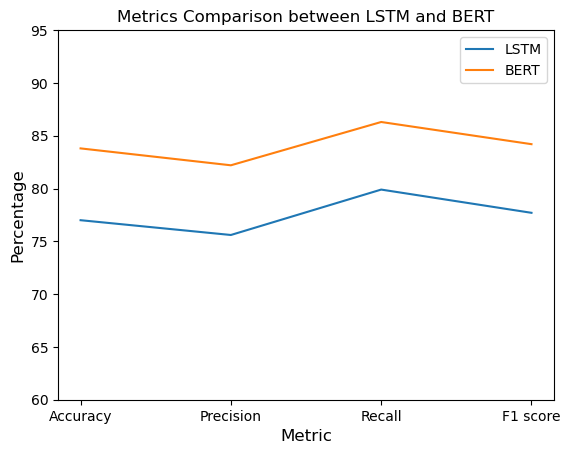

In [7]:
x = metrics
y1 = lstm
y2 = bert

plt.plot(x, y1, label='LSTM')
plt.plot(x, y2, label='BERT')
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.ylim(60, 95)
plt.legend()
plt.title('Metrics Comparison between LSTM and BERT')
plt.show()